In [42]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the Titanic dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)

# Show the first few rows of the dataset
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
# Check for Mismatched Data Types and Inconsistencies

# Check data types of each column
print("Data types:\n")
print(data.dtypes)

# Check for unique values in categorical columns that should be categorical (e.g., 'Sex', 'Embarked', 'Pclass')
print("\nUnique values in 'Sex':")
print(data['Sex'].unique())

print("\nUnique values in 'Embarked':")
print(data['Embarked'].unique())

print("\nUnique values in 'Pclass':")
print(data['Pclass'].unique())

# Check for any unexpected non-numeric values in numeric columns (e.g., Age, Fare)
print("\nCheck for unexpected values in numeric columns:")
print(data[['Age', 'Fare']].apply(lambda x: pd.to_numeric(x, errors='coerce')).isnull().sum())


Data types:

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Unique values in 'Sex':
['male' 'female']

Unique values in 'Embarked':
['S' 'C' 'Q' nan]

Unique values in 'Pclass':
[3 1 2]

Check for unexpected values in numeric columns:
Age     177
Fare      0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


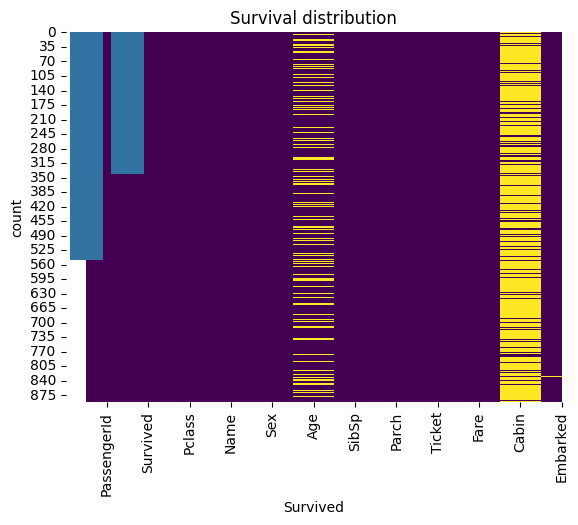

In [44]:
# EDA

data.info()


data.describe()

sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

sns.countplot(x='Survived', data=data)
plt.title('Survival distribution')
plt.show()




In [45]:
#Show total row count and missing values
total_rows = len(data)
null_counts = data.isnull().sum()
null_percentage = (null_counts / total_rows) * 100

# Create a summary DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
})

# Show columns with missing data only (Null Count > 0)
print(f"Total rows in the dataset: {total_rows}")
print("\nSummary of missing values in each column:")
print(null_summary[null_summary['Null Count'] > 0])

# Show columns with no missing data as well
print("\nColumns with no missing data:")
print(null_summary[null_summary['Null Count'] == 0])


Total rows in the dataset: 891

Summary of missing values in each column:
          Null Count  Null Percentage
Age              177        19.865320
Cabin            687        77.104377
Embarked           2         0.224467

Columns with no missing data:
             Null Count  Null Percentage
PassengerId           0              0.0
Survived              0              0.0
Pclass                0              0.0
Name                  0              0.0
Sex                   0              0.0
SibSp                 0              0.0
Parch                 0              0.0
Ticket                0              0.0
Fare                  0              0.0


In [46]:
# Data Cleaning

# Drop rows where Embarked is missing
data = data.dropna(subset=['Embarked'])

# Extract passenger titles
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace(['Mme'], 'Mrs')
rare_titles = data['Title'].value_counts()[data['Title'].value_counts() < 10].index
data['Title'] = data['Title'].replace(rare_titles, 'Rare')

# Family-based features
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch'])

# Fill missing values
data_cleaned['Age'].fillna(data_cleaned['Age'].median(), inplace=True)
data_cleaned['Fare'].fillna(data_cleaned['Fare'].median(), inplace=True)

# Encode categorical variables
data_cleaned['Sex'] = data_cleaned['Sex'].map({'male': 0, 'female': 1})
data_cleaned = pd.get_dummies(data_cleaned, columns=['Embarked', 'Pclass', 'Title'], drop_first=True)

# Final check
print("Missing values:\n", data_cleaned.isnull().sum())
print("\nColumns after cleaning:\n", data_cleaned.columns)


Missing values:
 Survived      0
Sex           0
Age           0
Fare          0
FamilySize    0
IsAlone       0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
Title_Miss    0
Title_Mr      0
Title_Mrs     0
Title_Rare    0
dtype: int64

Columns after cleaning:
 Index(['Survived', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Embarked_Q',
       'Embarked_S', 'Pclass_2', 'Pclass_3', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare'],
      dtype='object')


<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3391420978.py:7: SyntaxWarning: invalid escape sequence '\.'
  data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/tmp/ipython-input-3391420978.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Age'].fillna(data_cleaned['Age'].median(), inplace=True)
/tmp/ipython-input-3391420978.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through 

In [48]:
#  Feature Engineering

# (No need to re-encode Pclass — already done in cleaning step)

# Separate features and target
X = data_cleaned.drop(columns=['Survived'])
y = data_cleaned['Survived']

# Train-test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for any remaining missing values
print("Missing values in features before scaling:\n", X_train.isnull().sum().sum())

# Scale only numerical features (keep dummy variables as-is)
from sklearn.preprocessing import StandardScaler

num_cols = ['Age', 'Fare', 'FamilySize']  # numerical columns that need scaling
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("\nFeature scaling complete. Shape of training data:", X_train_scaled.shape)


Missing values in features before scaling:
 0

Feature scaling complete. Shape of training data: (711, 13)


In [49]:
# Model Training

# Train a Logistic Regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_scaled, y_train)

# Train a Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set using both models
log_reg_preds = log_reg_model.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test_scaled)


Logistic Regression Evaluation
Accuracy: 0.8258426966292135
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       109
           1       0.76      0.80      0.78        69

    accuracy                           0.83       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178

Random Forest Evaluation
Accuracy: 0.7696629213483146
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       109
           1       0.67      0.80      0.73        69

    accuracy                           0.77       178
   macro avg       0.76      0.77      0.76       178
weighted avg       0.78      0.77      0.77       178



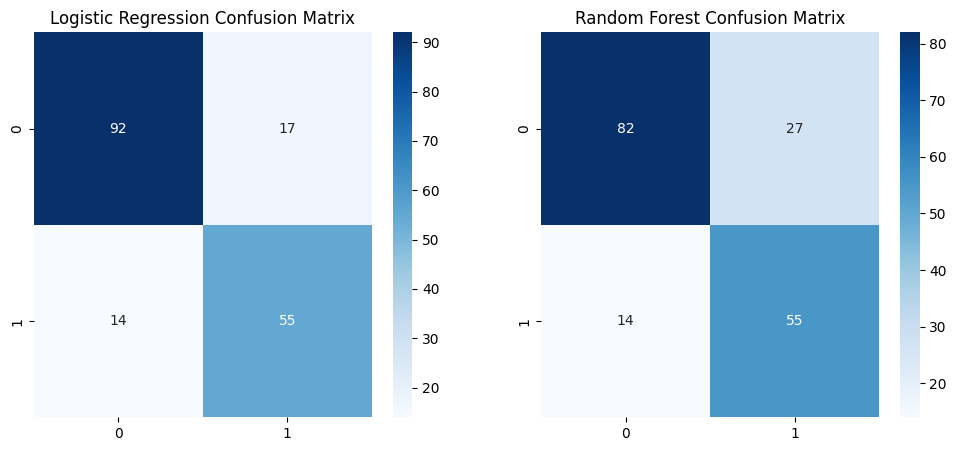

In [50]:
# Model Evaluation

# Logistic Regression Evaluation
print("Logistic Regression Evaluation")
print("Accuracy:", accuracy_score(y_test, log_reg_preds))
print(classification_report(y_test, log_reg_preds))

# Random Forest Evaluation
print("Random Forest Evaluation")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
sns.heatmap(confusion_matrix(y_test, log_reg_preds), annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title('Random Forest Confusion Matrix')

plt.show()


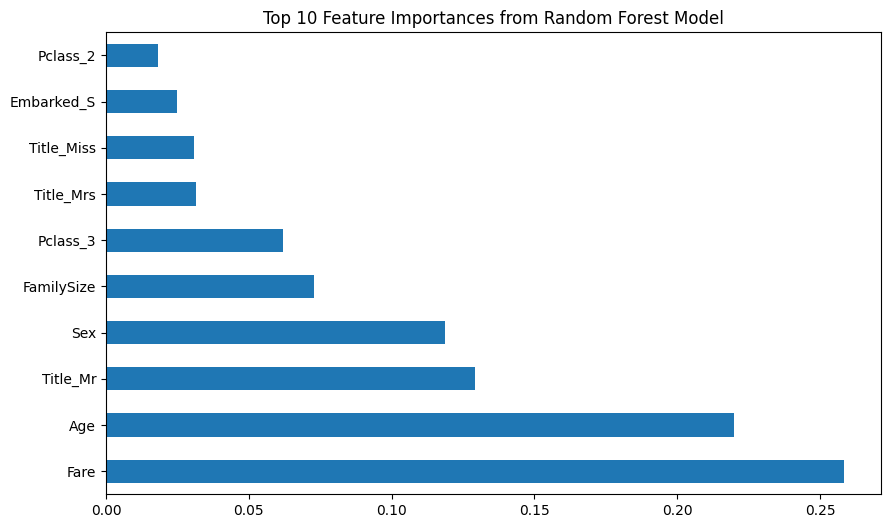

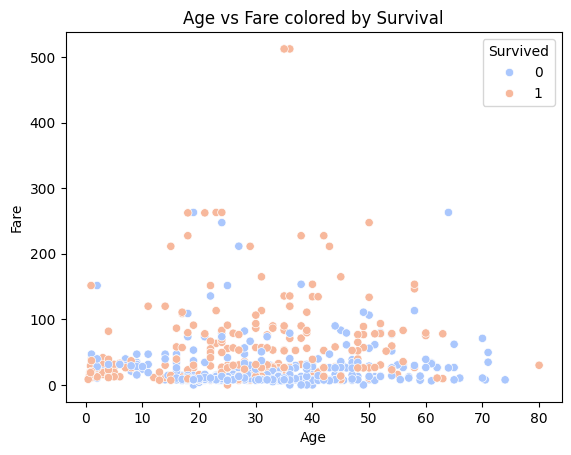

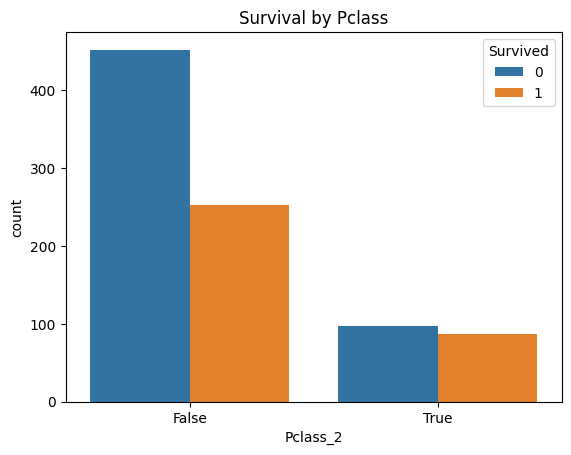

In [51]:
# Visualizations and Insights

# Visualize feature importance from Random Forest model
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Feature Importances from Random Forest Model')
plt.show()

# Visualize the correlation between 'Age' and 'Fare' with survival
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=data, palette='coolwarm')
plt.title('Age vs Fare colored by Survival')
plt.show()

# Visualize survival distribution across 'Pclass'
sns.countplot(x='Pclass_2', hue='Survived', data=data_cleaned)
plt.title('Survival by Pclass')
plt.show()


In [52]:
#Tune Hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
print("Best RF Accuracy:", grid_rf.best_score_)
print("Best Parameters:", grid_rf.best_params_)


Best RF Accuracy: 0.8607603663941692
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [53]:
#Cross-Validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10)
print("Cross-validation Accuracy:", scores.mean())


Cross-validation Accuracy: 0.8326682316118935
